# Document-level Topic Modeling, LDA & LDA Mallet

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm import tqdm_notebook

import nltk
import spacy

import gensim
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use('ggplot')

In [3]:
import logging
logging.basicConfig(filename='./logs/gensim.log',
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.INFO)

In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Load Datasets

In [5]:
df_news = pd.read_json('./datasets/news_groups.json') # grasp from https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json
df_news.head()

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
100,From: tchen@magnus.acs.ohio-state.edu (Tsung-K...,6,misc.forsale
1000,From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\n...,2,comp.os.ms-windows.misc


In [6]:
print(f'TOPIC EXAMPLES ({len(df_news.target_names.unique())} Topics):\n')
print(', '.join(df_news.target_names.unique()))

TOPIC EXAMPLES (20 Topics):

rec.autos, comp.sys.mac.hardware, rec.motorcycles, misc.forsale, comp.os.ms-windows.misc, alt.atheism, comp.graphics, rec.sport.baseball, rec.sport.hockey, sci.electronics, sci.space, talk.politics.misc, sci.med, talk.politics.mideast, soc.religion.christian, comp.windows.x, comp.sys.ibm.pc.hardware, talk.politics.guns, talk.religion.misc, sci.crypt


## Preprocess Datasets

In [7]:
from nltk.corpus import stopwords

In [8]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

#### 1) Removing e-mails, new line characters and single quotes

In [9]:
content = df_news['content'].values.tolist()

# removing e-mails
cleaned_content = [re.sub('\S*@\S*\s?', '', sentence) for sentence in content]

# removing new line characters
cleaned_content = [re.sub('\s+', ' ', sentence) for sentence in cleaned_content]

# removing single quotes
cleaned_content = [re.sub("\'", "", sentence) for sentence in cleaned_content]

In [10]:
df_news['cleaned_content'] = cleaned_content
df_news[['content', 'cleaned_content']].head()

,content,cleaned_content
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,From: (wheres my thing) Subject: WHAT car is t...
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,From: (Guy Kuo) Subject: SI Clock Poll - Final...
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,From: (Irwin Arnstein) Subject: Re: Recommenda...
100,From: tchen@magnus.acs.ohio-state.edu (Tsung-K...,From: (Tsung-Kun Chen) Subject: ** Software fo...
1000,From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\n...,From: (Don A.B. Lindbergh) Subject: Diamond SS...


#### 2) Tokenizing each sentence and removing punctuations, unnecessary characters also stop words

In [11]:
from gensim.utils import simple_preprocess

In [12]:
def tokenize_sentences(sentences):
    for sentence in tqdm_notebook(sentences):
        tokenized_sentence = simple_preprocess(str(sentence), deacc=True)
        tokenized_sentence = [word for word in tokenized_sentence if word not in stop_words]
        yield(tokenized_sentence) # true means removing punctuations

In [13]:
tokenized_sentences = list(tokenize_sentences(cleaned_content))

In [14]:
df_news['tokenized_content'] = tokenized_sentences
df_news[['content', 'tokenized_content']].head()

,content,tokenized_content
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,"[wheres, thing, car, nntp, posting, host, rac,..."
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,"[guy, kuo, si, clock, poll, final, call, summa..."
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,"[irwin, arnstein, recommendation, duc, summary..."
100,From: tchen@magnus.acs.ohio-state.edu (Tsung-K...,"[tsung, kun, chen, software, forsale, lots, nn..."
1000,From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\n...,"[lindbergh, diamond, ss, win, mouse, cursor, o..."


#### 3) Making Bigram & Tigram Words

In [15]:
# create the model first
bigram = gensim.models.Phrases(tokenized_sentences, min_count=5, threshold=100) # higher threshold fewer phrases
trigram = gensim.models.Phrases(bigram[tokenized_sentences], threshold=100)

bigram_model = gensim.models.phrases.Phraser(bigram)
trigram_model = gensim.models.phrases.Phraser(trigram)

In [16]:
def make_bigram_words(text): return [bigram_model[word] for word in tqdm_notebook(text)]
def make_trigram_words(text): return [trigram_model[bigram_model[word]] for word in tqdm_notebook(text)]

In [17]:
bigram_words = make_bigram_words(tokenized_sentences)

print('BIGRAM EXAMPLES:\n')
print(', '.join(bigram_words[0]))


BIGRAM EXAMPLES:

wheres, thing, car, nntp_posting, host, rac_wam, umd, organization, university, maryland_college, park, lines, wondering, anyone, could, enlighten, car, saw, day, door, sports, car, looked, late, early, called, bricklin, doors, really, small, addition, front_bumper, separate, rest, body, know, anyone, tellme, model, name, engine, specs, years, production, car, made, history, whatever, info, funky, looking, car, please, mail, thanks, il, brought, neighborhood, lerxst


In [18]:
trigram_words = make_trigram_words(tokenized_sentences)

print('TRIGRAM EXAMPLES:\n')
print(', '.join(trigram_words[0]))


TRIGRAM EXAMPLES:

wheres, thing, car, nntp_posting_host, rac_wam_umd, organization, university_maryland_college, park, lines, wondering, anyone, could, enlighten, car, saw, day, door, sports, car, looked, late, early, called, bricklin, doors, really, small, addition, front_bumper, separate, rest, body, know, anyone, tellme, model, name, engine, specs, years, production, car, made, history, whatever, info, funky, looking, car, please, mail, thanks, il, brought, neighborhood, lerxst


#### 4) Lemmatizing Words

In [19]:
def lemmatize_words(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    
    nlp = spacy.load('en', disable=['parser', 'ner'])
        
    lemmatized_words = []
    
    for sentence in tqdm_notebook(text):
        doc = nlp(' '.join(sentence))
        lemmatized_words.append([word.lemma_ for word in doc if word.pos_ in allowed_postags])
        
    return lemmatized_words

In [20]:
lemmatized_words = lemmatize_words(bigram_words)

In [21]:
print('LEMMATIZATION EXAMPLES:\n')
print(', '.join(lemmatized_words[0]))

LEMMATIZATION EXAMPLES:

where, s, thing, car, nntp_posting, host, line, wonder, enlighten, car, see, day, door, sport, car, look, late, early, call, door, really, small, addition, front_bumper, separate, rest, body, know, year, production, car, make, history, info, funky, look, car, mail, thank, bring, neighborhood, lerxst


#### 5) Creating the dictionary and corpus

In [22]:
import gensim.corpora as corpora

In [23]:
id2word = corpora.Dictionary(lemmatized_words)

#### 6) Preparing text features using bag of words

In [24]:
corpus = [id2word.doc2bow(text) for text in tqdm_notebook(lemmatized_words)]

In [25]:
corpus_look = []
for index, frequency in corpus[:1][0][:10]: corpus_look.append(f'{id2word[index]} {frequency}')
print(', '.join(corpus_look))

addition 1, body 1, bring 1, call 1, car 5, day 1, door 2, early 1, enlighten 1, front_bumper 1


## Build Model

#### 1) LDA Model

In [26]:
from gensim.models.ldamodel import LdaModel

In [27]:
# official documentation of the LdaModel: https://radimrehurek.com/gensim/models/ldamodel.html
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=20, chunksize=100, 
                     passes=10, eval_every=1, update_every=1, per_word_topics=True, alpha='auto', random_state=10)

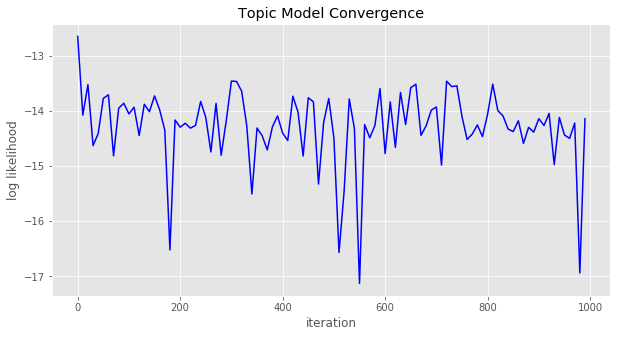

In [28]:
p = re.compile("(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity")
matches = [p.findall(l) for l in open('./logs/gensim.log')]
matches = [m for m in matches if len(m) > 0]

tuples = [t[0] for t in matches]
perplexity = [float(t[1]) for t in tuples]
likelihood = [float(t[0]) for t in tuples]
iteration = list(range(0,len(tuples)*10,10))
plt.figure(figsize=(10,5))
plt.plot(iteration[:100], likelihood[:100], c="blue")
plt.ylabel("log likelihood")
plt.xlabel("iteration")
plt.title("Topic Model Convergence")
plt.show()

#### 2) LDA Mallet Model

In [29]:
from gensim.models.wrappers import LdaMallet

In [30]:
# official documentation of the LdaMallet: https://radimrehurek.com/gensim/models/wrappers/ldamallet.html
# download weight here: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
ldamallet_path = './weights/mallet-2.0.8/bin/mallet'
ldamallet_model = LdaMallet(ldamallet_path, corpus=corpus, id2word=id2word, num_topics=20)

## View The Topics in LDA Model

#### 1) LDA Model

In [31]:
pprint(lda_model.print_topics(num_words=10))
doc_lda = lda_model[corpus]

[(0,
  '0.255*"image" + 0.032*"shadow" + 0.023*"atmosphere" + 0.022*"sun" + '
  '0.019*"cycle" + 0.013*"neighborhood" + 0.011*"mapping" + 0.010*"permanent" '
  '+ 0.006*"observatory" + 0.005*"sunlight"'),
 (1,
  '0.143*"nntp_posting" + 0.118*"package" + 0.073*"quality" + 0.057*"purchase" '
  '+ 0.051*"advance" + 0.027*"presentation" + 0.026*"street" + 0.021*"pack" + '
  '0.005*"prohibition" + 0.004*"precision"'),
 (2,
  '0.121*"law" + 0.042*"moral" + 0.037*"punishment" + 0.036*"relate" + '
  '0.028*"fund" + 0.027*"establish" + 0.024*"court" + 0.023*"deny" + '
  '0.023*"recognize" + 0.021*"minority"'),
 (3,
  '0.038*"space" + 0.037*"cost" + 0.035*"chip" + 0.033*"low" + 0.024*"year" + '
  '0.023*"rate" + 0.023*"company" + 0.023*"phone" + 0.022*"high" + '
  '0.019*"hockey"'),
 (4,
  '0.064*"system" + 0.028*"key" + 0.021*"message" + 0.020*"standard" + '
  '0.016*"bit" + 0.016*"technology" + 0.015*"provide" + 0.014*"access" + '
  '0.014*"new" + 0.013*"obvious"'),
 (5,
  '0.092*"mail" + 0.06

#### 2) LDA Mallet Model

In [32]:
pprint(ldamallet_model.print_topics(num_words=10))
doc_ldamallet = ldamallet_model[corpus]

[(0,
  '0.031*"gun" + 0.014*"people" + 0.014*"make" + 0.011*"kill" + 0.011*"crime" '
  '+ 0.011*"weapon" + 0.009*"firearm" + 0.008*"drug" + 0.008*"fire" + '
  '0.008*"problem"'),
 (1,
  '0.044*"file" + 0.021*"program" + 0.018*"image" + 0.016*"include" + '
  '0.014*"software" + 0.013*"version" + 0.011*"source" + 0.010*"information" + '
  '0.009*"format" + 0.009*"number"'),
 (2,
  '0.035*"line" + 0.026*"price" + 0.022*"buy" + 0.022*"sell" + 0.019*"good" + '
  '0.014*"sale" + 0.012*"offer" + 0.011*"cheap" + 0.011*"company" + '
  '0.010*"high"'),
 (3,
  '0.018*"space" + 0.011*"system" + 0.009*"launch" + 0.008*"project" + '
  '0.007*"design" + 0.007*"year" + 0.007*"technology" + 0.007*"base" + '
  '0.006*"satellite" + 0.006*"earth"'),
 (4,
  '0.032*"drive" + 0.028*"card" + 0.026*"system" + 0.025*"problem" + '
  '0.020*"driver" + 0.019*"work" + 0.015*"bit" + 0.015*"run" + 0.014*"disk" + '
  '0.013*"speed"'),
 (5,
  '0.016*"people" + 0.014*"armenian" + 0.010*"israeli" + 0.009*"attack" + '
  '

## Evaluate By Model Perplexity and Coherence Score

#### 1) LDA Model

In [33]:
# computing Perplexity
perplexity_score = lda_model.log_perplexity(corpus)
print(f'\nPerplexity Score: {perplexity_score:6f}') # lower the better

# computing Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=lemmatized_words, dictionary=id2word, coherence='c_v')
coherence_score = coherence_model_lda.get_coherence()
print(f'\nCoherence Score: {coherence_score:6f}') # higher the better


Perplexity Score: -14.198199

Coherence Score: 0.462291


#### 2) LDA Mallet Model

In [34]:
# computing Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet_model, texts=lemmatized_words, dictionary=id2word, coherence='c_v')
coherence_score = coherence_model_ldamallet.get_coherence()
print(f'\nCoherence Score: {coherence_score:6f}') # higher the better


Coherence Score: 0.529833


## Find Optimal Number of Topics for LDA Model

In [35]:
def find_optimal_number_of_topics(dictionary, corpus, texts, end, start=2, step=3):
    
    model_list = []
    coherence_scores = []
    
    for num_topics in tqdm_notebook(range(start, end, step)):
        model = LdaMallet(ldamallet_path, corpus=corpus, id2word=id2word, num_topics=num_topics)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        
        model_list.append(model)
        coherence_scores.append(coherence_model.get_coherence())
        
        print(f'Number of Topics: {num_topics}, Coherence Score: {coherence_model.get_coherence():.4f}')
        
    return model_list, coherence_scores

In [36]:
start=2; end=50; step=6;
model_list, coherence_scores = find_optimal_number_of_topics(dictionary=id2word, corpus=corpus, texts=lemmatized_words, start=start, end=end, step=step)

Number of Topics: 2, Coherence Score: 0.4046
Number of Topics: 8, Coherence Score: 0.4579
Number of Topics: 14, Coherence Score: 0.5075
Number of Topics: 20, Coherence Score: 0.5363
Number of Topics: 26, Coherence Score: 0.5481
Number of Topics: 32, Coherence Score: 0.5300
Number of Topics: 38, Coherence Score: 0.5292
Number of Topics: 44, Coherence Score: 0.5391



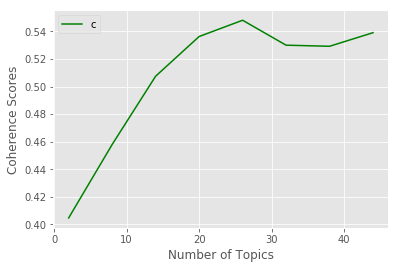

In [37]:
x = range(start, end, step)
plt.plot(x, coherence_scores, color='green')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Scores')
plt.legend(('coherence_scores'), loc='best')
plt.savefig('./images/plot_optimal_number_of_topics.png')
plt.show()

## View The Topics in Optimal LDA Model

In [38]:
number_of_model = 4

In [39]:
optimal_lda_model = model_list[number_of_model]
optimal_lda_model.save('./weights/optimal_ldamallet_model.hdf5')

In [40]:
optimal_lda_model_topics = optimal_lda_model.show_topics(formatted=False)
pprint(optimal_lda_model.print_topics(num_words=10))
doc_optimal_lda = optimal_lda_model[corpus]

[(18,
  '0.051*"drive" + 0.037*"line" + 0.035*"buy" + 0.032*"price" + 0.028*"sell" + '
  '0.018*"sale" + 0.013*"offer" + 0.012*"cheap" + 0.012*"include" + '
  '0.012*"disk"'),
 (17,
  '0.048*"key" + 0.018*"encryption" + 0.017*"system" + 0.014*"government" + '
  '0.014*"bit" + 0.013*"chip" + 0.013*"public" + 0.012*"phone" + '
  '0.011*"security" + 0.011*"technology"'),
 (4,
  '0.028*"people" + 0.015*"system" + 0.015*"write" + 0.014*"man" + '
  '0.013*"person" + 0.013*"moral" + 0.011*"human" + 0.010*"life" + '
  '0.009*"opinion" + 0.009*"society"'),
 (23,
  '0.051*"time" + 0.036*"find" + 0.034*"point" + 0.028*"problem" + '
  '0.024*"book" + 0.023*"give" + 0.021*"work" + 0.018*"call" + 0.017*"line" + '
  '0.015*"read"'),
 (2,
  '0.044*"year" + 0.039*"good" + 0.021*"run" + 0.019*"hit" + 0.016*"win" + '
  '0.014*"game" + 0.014*"lose" + 0.012*"player" + 0.011*"baseball" + '
  '0.010*"team"'),
 (22,
  '0.052*"post" + 0.037*"mail" + 0.028*"send" + 0.025*"group" + 0.022*"list" + '
  '0.021*"inf

## Understand The Topics

#### 1) Finding the dominant topic in each document

In [43]:
def find_the_dominant_topic_in_each_sentence(lda_model=lda_model, corpus=corpus, texts=cleaned_content):
    
    # init dataframe
    df_dominant_topic = pd.DataFrame()
    
    # get main topic in each document
    for i, row in enumerate(tqdm_notebook(lda_model[corpus])):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # get the dominant topic, percentage of contribution and keywords for each document
        for j, (topic_number, topic_percentage) in enumerate(row):
            if j == 0:
                wp = lda_model.show_topic(topic_number)
                topic_keywords = ', '.join([word for word, probability in wp])
                df_dominant_topic = df_dominant_topic.append(pd.Series([int(topic_number), round(topic_percentage, 4), topic_keywords]), ignore_index=True)
            else: break
    
    # add original text to the end of the output
    contents = pd.Series(texts)
    df_dominant_topic = pd.concat([df_dominant_topic, contents], axis=1)
    
    # reset and change dataframe index
    df_dominant_topic = df_dominant_topic.reset_index(drop=True)
    df_dominant_topic.columns = ['Dominant Topic', '(Topic) Percentage', 'Keywords', 'Documents']

    # save dataframe
    df_dominant_topic.to_csv('./results/df_dominant_topic.csv')
    
    return (df_dominant_topic)

In [44]:
df_dominant_topic = find_the_dominant_topic_in_each_sentence(lda_model = optimal_lda_model, corpus=corpus, texts=cleaned_content)
df_dominant_topic.head(10)

,Dominant Topic,(Topic) Percentage,Keywords,Documents
0,21.0,0.1209,"car, bike, ride, engine, road, turn, speed, fr...",From: (wheres my thing) Subject: WHAT car is t...
1,19.0,0.1369,"card, problem, system, driver, run, bit, memor...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,21.0,0.1382,"car, bike, ride, engine, road, turn, speed, fr...",From: (Irwin Arnstein) Subject: Re: Recommenda...
3,10.0,0.1272,"window, set, application, display, server, run...",From: (Tsung-Kun Chen) Subject: ** Software fo...
4,19.0,0.1612,"card, problem, system, driver, run, bit, memor...",From: (Don A.B. Lindbergh) Subject: Diamond SS...
5,21.0,0.3839,"car, bike, ride, engine, road, turn, speed, fr...",From: (Robert Loper) Subject: Re: SHO and SC N...
6,18.0,0.1332,"drive, line, buy, price, sell, sale, offer, ch...",From: (Kim Richard Man) Subject: SyQuest 44M c...
7,25.0,0.1415,"image, software, include, version, program, fi...",From: (Kirtley Wilson) Subject: Mirosoft Offic...
8,0.0,0.1208,"gun, law, state, crime, weapon, case, people, ...",Subject: Re: Dont more innocents die without t...
9,13.0,0.2688,"question, exist, claim, reason, true, evidence...",From: (Jon Livesey) Subject: Re: Genocide is C...


#### 2) Finding the top representative document for each topic

In [47]:
def find_the_most_representative_document_for_each_topic(df_dominant_topic):

    # init dataframe
    df_representative_document = pd.DataFrame()

    for i, group in tqdm_notebook(df_dominant_topic.groupby('Dominant Topic')):
        
        group = group[['Dominant Topic', '(Topic) Percentage', 'Keywords', 'Documents']]
        df_representative_document = pd.concat([df_representative_document, 
                                                group.sort_values(['(Topic) Percentage'], ascending=[0]).head(1)], axis=0)
        
    # reset and change dataframe index
    df_representative_document = df_representative_document.reset_index(drop=True)
    df_representative_document.columns = ['Number of Topic', '(Topic) Percentage', 'Keywords', 'Top Documents']
    
    # save dataframe
    df_representative_document.to_csv('./results/df_representative_document.csv')
    
    return (df_representative_document)

In [48]:
df_representative_document = find_the_most_representative_document_for_each_topic(df_dominant_topic)
df_representative_document

,Number of Topic,(Topic) Percentage,Keywords,Top Documents
0,0.0,0.6335,"gun, law, state, crime, weapon, case, people, ...",From: (Larry Cipriani) Subject: Ohio House Bil...
1,1.0,0.6670,"word, church, christian, people, religion, lov...",From: (Robert Weiss) Subject: [lds] Ricks repl...
2,2.0,0.6508,"year, good, run, hit, win, game, lose, player,...",From: (Edward [Ted] Fischer) Subject: Old Pred...
3,3.0,0.7493,"state, israeli, people, write, give, land, cou...",From: Center for Policy Research Subject: Fina...
4,4.0,0.5505,"people, system, write, man, person, moral, hum...",From: (Keith Allan Schneider) Subject: Re: Obj...
5,5.0,0.6627,"high, large, number, low, rate, level, small, ...",From: (John De Armond) Subject: Re: What do Nu...
6,6.0,0.7390,"team, game, play, player, line, season, point,...",From: (bryan.k.strouse) Subject: NHL RESULTS F...
7,7.0,0.8229,"people, start, time, day, leave, happen, fire,...",From: (David Davidian) Subject: Accounts of An...
8,8.0,0.9720,"ax, line, host, nntp_posting, reply, _, part, ...",Subject: roman.bmp 12/14 From: (Cliff) Reply-T...
9,9.0,0.7827,"make, work, government, money, year, pay, job,...",From: (Clinton/Gore 92) Subject: CLINTON: Back...


#### 3) Finding topic distribution across documents 

In [49]:
def find_topic_distribution_across_documents(df_dominant_topic):

    # init dataframe
    df_topic_distribution = pd.DataFrame()

    # number of documents for each topic
    topic_counts = df_dominant_topic['Dominant Topic'].value_counts()

    # percentage of documents for each topic
    topic_contribution = round(topic_counts/ topic_counts.sum(), 4)

    # topic number and keywords
    topic_keywords = df_dominant_topic[['Dominant Topic', 'Keywords']]

    # concatenate column wise
    df_topic_distribution = pd.concat([topic_keywords, topic_counts, topic_contribution], axis=1)

    # change column names
    df_topic_distribution.columns = ['Dominant Topic', 'Keywords', 'Number of Documents', '(Doc) Percentage']
    
    # save dataframe
    df_topic_distribution.to_csv('./results/df_topic_distribution.csv')
    
    return (df_topic_distribution)

In [50]:
df_topic_distribution = find_topic_distribution_across_documents(df_dominant_topic)
df_topic_distribution.head(10)

,Dominant Topic,Keywords,Number of Documents,(Doc) Percentage
0,21.0,"car, bike, ride, engine, road, turn, speed, fr...",501.0,0.0443
1,19.0,"card, problem, system, driver, run, bit, memor...",568.0,0.0502
2,21.0,"car, bike, ride, engine, road, turn, speed, fr...",490.0,0.0433
3,10.0,"window, set, application, display, server, run...",321.0,0.0284
4,19.0,"card, problem, system, driver, run, bit, memor...",327.0,0.0289
5,21.0,"car, bike, ride, engine, road, turn, speed, fr...",115.0,0.0102
6,18.0,"drive, line, buy, price, sell, sale, offer, ch...",597.0,0.0528
7,25.0,"image, software, include, version, program, fi...",253.0,0.0224
8,0.0,"gun, law, state, crime, weapon, case, people, ...",155.0,0.0137
9,13.0,"question, exist, claim, reason, true, evidence...",268.0,0.0237


## [Visualize](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/) The Topics in LDA Model

In [ ]:
visualize_the_topics = pyLDAvis.gensim.prepare(optimal_lda_model, corpus, id2word)
visualize_the_topics.display()

---